## Imports and Set up

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from scipy import integrate, signal
import sympy

In [2]:
# Set font size of plot elements\n",
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Functions

In [3]:
def photons_from_temp(ω_c, temp):
    hbar_ov_k = 7.639e-12
    return (np.exp(hbar_ov_k * ω_c / temp) - 1) ** -1

In [4]:
def temp_from_photons(ω_c, num_photons):
    hbar_ov_k = 7.639e-12 
    return hbar_ov_k * ω_c / np.log(1 / num_photons + 1)

In [5]:
def get_photons_a_no_NV(ω_bounds, κ, γ, ϕ, na, ne, nb, β, Sϕ):
    """
    function for calculating the number of phonts in output a (i.e. reflection) when the NV ensemble is not connected
    :param ω_bounds:  the frequency bounds to use for integration
    :param κ:         the output coupling rate on port a
    :param γ:         the internal loss rate of the cavity
    :param ϕ:         the output coupling rate on port e
    :param na:        the number of photons associated with noise on the input port
    :param ne:        the number of photons associated with the noise on the output port
    :param nb:        the number of photons associated with the internal loss of the cavity
    :param β:         the square root of the amplitude of the coherent input
    :param Sϕ:        the phase noise power spectral density
    :return:          the number of noise photons, signal photons, and total photons
    """
    # Noise part first
    den = np.abs((κ + γ + ϕ) / 2 - 1j * ω_bounds) ** 2
    noise_term = (κ * γ * nb + κ * ϕ * ne + np.abs((κ - γ - ϕ) / 2 + 1j * ω_bounds) ** 2 * na) / den
    noise_photons = integrate.simpson(noise_term, x=ω_bounds)

    phase_noise_photons = integrate.simpson(np.abs((κ - γ - ϕ) / 2 + 1j * ω_bounds) ** 2  / den * Sϕ, x=ω_bounds)

    noise_photons += phase_noise_photons

    # Now signal term
    signal_photons = np.abs((κ - γ - ϕ) / 2) ** 2  / np.abs((κ + γ + ϕ) / 2) ** 2 * np.abs(β) ** 2

    return noise_photons, signal_photons, noise_photons + signal_photons

In [15]:
def get_photons_e_no_NV(ω_bounds, κ, γ, ϕ, na, ne, nb, β, Sϕ):
    """
    function for calculating the number of phonts in output e (i.e. transmission) when the NV ensemble is not connected
    :param ω_bounds:  the frequency bounds to use for integration
    :param κ:         the output coupling rate on port a
    :param γ:         the internal loss rate of the cavity
    :param ϕ:         the output coupling rate on port e
    :param na:        the number of thermal photons from the environment
    :param ne:        the number of photons associated with the noise on the output port
    :param nb:        the number of photons associated with the internal loss of the cavity
    :param β:         the square root of the amplitude of the coherent input
    :param Sϕ:        the phase noise power spectral density
    :return:          the number of noise photons, signal photons, and total photons
    """
    # Noise part first
    den = np.abs((κ + γ + ϕ) / 2 - 1j * ω_bounds) ** 2
    noise_term = (ϕ * κ * na + ϕ * γ * nb + np.abs((ϕ - κ - γ) / 2 + 1j * ω_bounds) ** 2 * ne) / den
    noise_photons = integrate.simpson(noise_term, x=ω_bounds)

    phase_noise_photons = integrate.simpson( ϕ * κ  / np.abs((κ + γ + ϕ) / 2 - 1j * ω_bounds) ** 2 * Sϕ, x=ω_bounds)

    noise_photons += phase_noise_photons

    # Now signal term
    signal_photons = ϕ * κ  / np.abs((κ + γ + ϕ) / 2) ** 2 * np.abs(β) ** 2

    return noise_photons, signal_photons, noise_photons + signal_photons

In [16]:
def get_photons_a(ω_bounds, κ, γ, ϕ, g, r, na, ne, nb, nc, β, Sϕ):
    """
    function for calculating the number of phonts in output a (i.e. reflection) when the NV ensemble is connected
    :param ω_bounds:  the frequency bounds to use for integration
    :param κ:         the output coupling rate on port a
    :param γ:         the internal loss rate of the cavity
    :param ϕ:         the output coupling rate on port e
    :param g:         the collective coupling strength between the cavity and the ensemble
    :param r:         the inhomogenous broadening of the spins
    :param na:        the number of thermal photons from the environment
    :param ne:        the number of photons associated with the noise on the output port
    :param nb:        the number of photons associated with the internal loss of the cavity
    :param nc:        the effective number of photons from the cold spin ensemble
    :param β:         the square root of the amplitude of the coherent input
    :param Sϕ:        the phase noise power spectral density
    :return:          the number of noise photons, signal photons, and total photons
    """
    # To do the integration, we have to separate out the β term
    β_term = np.abs(((κ - γ - ϕ) / 2) * (r / 2) - g ** 2) ** 2 / np.abs(((κ + γ + ϕ) / 2) * (r / 2) + g ** 2) ** 2 * np.abs(β) ** 2
    
    # Now set up the rest
    num = (r ** 2 / 4 + ω_bounds ** 2) * (κ * γ * nb + κ * ϕ * ne) + κ * r * g ** 2 * nc
    num += np.abs(((κ - γ - ϕ) / 2 + 1j * ω_bounds) * (r / 2 - 1j * ω_bounds) - g ** 2) ** 2 * na

    den = np.abs(((κ + γ + ϕ) / 2 - 1j * ω_bounds) * (r / 2 - 1j * ω_bounds) + g ** 2) ** 2

    noise_term = integrate.simpson(num / den, x=ω_bounds) 
    noise_term += integrate.simpson(np.abs(((κ - γ - ϕ) / 2 + 1j * ω_bounds) * (r / 2 - 1j * ω_bounds) - g ** 2) ** 2 / den * Sϕ, x=ω_bounds)

    return noise_term, β_term, noise_term + β_term

In [8]:
def get_photons_e(ω_bounds, κ, γ, ϕ, g, r, na, ne, nb, nc, β, Sϕ):
    """
    function for calculating the number of phonts in output a (i.e. reflection) when the NV ensemble is connected
    :param ω_bounds:  the frequency bounds to use for integration
    :param κ:         the output coupling rate on port a
    :param γ:         the internal loss rate of the cavity
    :param ϕ:         the output coupling rate on port e
    :param g:         the collective coupling strength between the cavity and the ensemble
    :param r:         the inhomogenous broadening of the spins
    :param na:        the number of thermal photons from the environment
    :param ne:        the number of photons associated with the noise on the output port
    :param nb:        the number of photons associated with the internal loss of the cavity
    :param nc:        the effective number of photons from the cold spin ensemble
    :param β:         the square root of the amplitude of the coherent input
    :param Sϕ:        the phase noise power spectral density
    :return:          the number of noise photons, signal photons, and total photons
    """
    # To do the integration, we need to separate out the β term
    β_term = (r ** 2 / 4) * ϕ * κ / np.abs(((κ + γ + ϕ) / 2) * (r / 2) + g ** 2) ** 2 * np.abs(β) ** 2

    # Now do the rest
    num = (r ** 2 / 4 + ω_bounds ** 2) * (ϕ * κ * na + ϕ * γ * nb) + ϕ * r * g ** 2 * nc
    num += np.abs(((ϕ - κ - γ) / 2 + 1j * ω_bounds) * (r / 2 - 1j * ω_bounds) - g ** 2) ** 2 * ne
    den = np.abs(((κ + γ + ϕ) / 2 - 1j * ω_bounds) * (r / 2 - 1j * ω_bounds) + g ** 2) ** 2

    noise_term = integrate.simpson(num / den, x=ω_bounds) 
    noise_term += integrate.simpson((r ** 2 / 4 + ω_bounds ** 2) * ϕ * κ / den * Sϕ, x=ω_bounds)
    
    return noise_term, β_term, noise_term + β_term

In [19]:
def get_spectrum_e_no_NV(ω_bounds, κ, γ, ϕ, na, ne, nb):
    den = np.abs((κ + γ + ϕ) / 2 - 1j * ω_bounds) ** 2
    num = (ϕ * κ * na + ϕ * γ * nb + np.abs((ϕ - κ - γ) / 2 + 1j * ω_bounds) ** 2 * ne)
    return num / den

In [20]:
def get_spectrum_e(ω_bounds, κ, γ, ϕ, g, r, na, ne, nb, nc):
    num = (r ** 2 / 4 + ω_bounds ** 2) * (ϕ * κ * na + ϕ * γ * nb) + ϕ * r * g ** 2 * nc
    num += np.abs(((ϕ - κ - γ) / 2 + 1j * ω_bounds) * (r / 2 - 1j * ω_bounds) - g ** 2) ** 2 * ne
    den = np.abs(((κ + γ + ϕ) / 2 - 1j * ω_bounds) * (r / 2 - 1j * ω_bounds) + g ** 2) ** 2
    return num / den

## Calculations

In [9]:
# Define parameters
ωc = 2.87 * 2 * np.pi * 1e9
g = 1e6
r = 2 * g
Q = 1e6
γ = ωc / Q
κ = γ
P = 0.8
nc = 0.5 * (1 - P) / P
T = 5
nT = photons_from_temp(ωc, T)
ϕ = γ
β = np.sqrt(1e10)

# Set the power spectral density for the phase noise to a constant - we'll use nT for now
ω_bounds = np.linspace(-γ, γ, 1000)
Sϕ = nT * np.ones(ω_bounds.shape[0])

In [38]:
# Calculate the output signal and noise in terms of photons for the two cases - we're setting na, ne = 0 here
output_noise_no_NV, output_signal_no_NV, temp = get_photons_e_no_NV(ω_bounds, κ, γ, ϕ, 0, 0, nT, β, 0)
output_noise, output_signal, temp = get_photons_e(ω_bounds, κ, γ, ϕ, g, r, 0, 0, nT, nc, β, 0)

In [39]:
print("Noise Outputs")
print("Output noise No NV: ", output_noise_no_NV)
print("Output noise: ", output_noise)
print("")
print("Signal Outputs")
print("Output signal No NV: ", output_signal_no_NV)
print("Output signal: ", output_signal)
print("")
print("SNR")
print("No NV SNR: ", 10*np.log10(output_signal_no_NV / output_noise_no_NV))
print("NV SNR: ", 10*np.log10(output_signal / output_noise))

Noise Outputs
Output noise No NV:  57298.41058417837
Output noise:  55.21626706435202

Signal Outputs
Output signal No NV:  4444444444.444445
Output signal:  3082769.8772317646

SNR
No NV SNR:  48.89674906764085
NV SNR:  47.46874064195795


In [42]:
# Get the spectra to compare
no_NV_spectrum = get_spectrum_e_no_NV(0.1*ω_bounds, κ, γ, ϕ, 0, 0, nT)
NV_spectrum = get_spectrum_e(0.1*ω_bounds, κ, γ, ϕ, g, r, 0, 0, nT, nc)

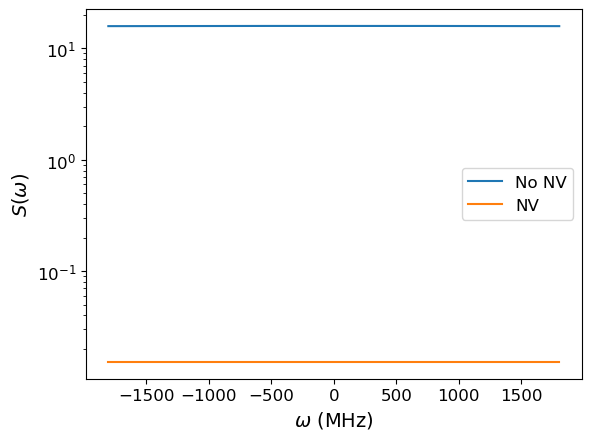

In [43]:
plt.semilogy(0.1*ω_bounds / 1e0, no_NV_spectrum, label='No NV')
plt.semilogy(0.1*ω_bounds / 1e0, NV_spectrum, label='NV')
plt.xlabel("$\\omega$ (MHz)")
plt.ylabel("$S(\\omega)$")
plt.legend()